In [1]:
import pandas as pd
import geopandas as gpd
from shapely import geometry, ops
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Initialises a StepModel with parametrised zones.

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [3]:
# Initialising StepModel...
sm = stepmodel.StepModel(debug=False,
                         walk_on_road=False,
                         epsg=4326,
                         coordinates_unit=None)

In [4]:
# Adding zones...
zones = gpd.read_file(input_path + "NUTS_RG_01M_2016_4326.geojson")
zones = zones[zones["CNTR_CODE"] == "DE"]
#zones = zones[zones["id"].str.startswith("DE73")] # only Kassel and surrounding
sm.zones = zones[zones["LEVL_CODE"]!=2] # NUTS-3 level and count(r)y borders 
sm.zones

,id,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,geometry
2,DE,DE,DEUTSCHLAND,0,DE,DE,"MULTIPOLYGON (((10.45444 47.55580, 10.43954 47..."
25,DE1,DE,BADEN-WÜRTTEMBERG,1,DE1,DE1,"MULTIPOLYGON (((10.08372 49.54356, 10.08747 49..."
27,DEA,DE,NORDRHEIN-WESTFALEN,1,DEA,DEA,"POLYGON ((8.70301 52.50044, 8.69906 52.48690, ..."
33,DE7,DE,HESSEN,1,DE7,DE7,"MULTIPOLYGON (((9.68533 51.58202, 9.69019 51.5..."
36,DE4,DE,BRANDENBURG,1,DE4,DE4,"MULTIPOLYGON (((14.41216 53.32964, 14.41496 53..."
...,...,...,...,...,...,...,...
1142,DEF0E,DE,Steinburg,3,DEF0E,DEF0E,"MULTIPOLYGON (((9.86433 54.01203, 9.84853 54.0..."
1143,DEF0F,DE,Stormarn,3,DEF0F,DEF0F,"MULTIPOLYGON (((10.53386 53.91881, 10.54342 53..."
1161,DEG0L,DE,Greiz,3,DEG0L,DEG0L,"POLYGON ((12.22417 50.94293, 12.22472 50.93943..."
1162,DEG0M,DE,Altenburger Land,3,DEG0M,DEG0M,"POLYGON ((12.61736 50.98079, 12.62094 50.97590..."


### Get information for NUTS cells

In [6]:
nuts_to_lau = pd.ExcelFile(input_path + 'NUTS_to_LAU.xls').parse('DE')
nuts_to_lau.columns = ['NUTS_ID', 'lau_id', 'lau_name', 'lau_name_latin', '_', 'population', 'area', 'urbanisation', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
nuts_to_lau = nuts_to_lau[['NUTS_ID', 'lau_id', 'lau_name', 'population', 'area', 'urbanisation']]
nuts_to_lau['lau_short'] = nuts_to_lau['lau_id'].astype(str).str[:-3]

In [7]:
nuts_to_lau.head()

,NUTS_ID,lau_id,lau_name,population,area,urbanisation,lau_short
0,DEF01,1001000,"Flensburg, Stadt",89504,56.73,1,1001
1,DEF02,1002000,"Kiel, Landeshauptstadt",247548,118.65,1,1002
2,DEF03,1003000,"Lübeck, Hansestadt",217198,214.19,1,1003
3,DEF04,1004000,"Neumünster, Stadt",79487,71.66,1,1004
4,DEF05,1051001,Albersdorf,3670,17.12,3,1051


In [8]:
nuts_to_lau_agg = nuts_to_lau[['population', 'area']].groupby(nuts_to_lau['NUTS_ID']).sum()
nuts_to_lau_agg['urbanisation'] = round(nuts_to_lau[['urbanisation']].groupby(nuts_to_lau['NUTS_ID']).mean())
nuts_to_lau_agg['lau_id'] = list(nuts_to_lau.drop_duplicates('NUTS_ID').sort_values(by='NUTS_ID')['lau_short'])

In [9]:
print(nuts_to_lau_agg.shape)
nuts_to_lau_agg.sample(2)

(401, 4)


,population,area,urbanisation,lau_id
NUTS_ID,,,,
DEA36,615261,761.32,2.0,5562
DE225,78355,983.86,3.0,9272


In [10]:
sm.zones.set_index('id', inplace=True)
#sm.zones = sm.zones.drop('FID', axis=1)

In [11]:
# Drops all other levels than NUTS 3
sm.zones = pd.merge(sm.zones, nuts_to_lau_agg, left_index=True, right_index=True)

In [12]:
print(sm.zones.shape)

(401, 10)


<AxesSubplot:>

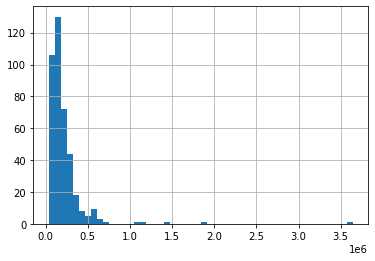

In [13]:
sm.zones['population'].hist(bins=50)

In [14]:
# What are the highest populated zones
sm.zones.sort_values('population').tail(15)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,geometry,population,area,urbanisation,lau_id
DEA2D,DE,Städteregion Aachen,3,DEA2D,DEA2D,"POLYGON ((6.41691 50.60930, 6.41878 50.60298, ...",555465,706.92,2.0,5334
DE501,DE,"Bremen, Kreisfreie Stadt",3,DE501,DE501,"MULTIPOLYGON (((8.91583 53.01102, 8.90611 53.0...",569352,317.83,1.0,4011
DEA13,DE,"Essen, Kreisfreie Stadt",3,DEA13,DEA13,"POLYGON ((7.13603 51.42604, 7.13506 51.41888, ...",583109,210.34,1.0,5113
DEA52,DE,"Dortmund, Kreisfreie Stadt",3,DEA52,DEA52,"POLYGON ((7.31460 51.52232, 7.32545 51.52303, ...",587010,280.71,1.0,5913
DED51,DE,"Leipzig, Kreisfreie Stadt",3,DED51,DED51,"POLYGON ((12.49874 51.36050, 12.50915 51.34769...",587857,297.80,1.0,14713
DEA2C,DE,Rhein-Sieg-Kreis,3,DEA2C,DEA2C,"POLYGON ((7.39848 50.94975, 7.41410 50.94683, ...",599780,1153.21,2.0,5382
DEA36,DE,Recklinghausen,3,DEA36,DEA36,"POLYGON ((7.40955 51.66458, 7.41767 51.66215, ...",615261,761.32,2.0,5562
DEA11,DE,"Düsseldorf, Kreisfreie Stadt",3,DEA11,DEA11,"POLYGON ((6.85605 51.12619, 6.84978 51.13341, ...",619294,217.41,1.0,5111
DE111,DE,"Stuttgart, Stadtkreis",3,DE111,DE111,"POLYGON ((9.24417 48.84701, 9.23897 48.84186, ...",634830,207.33,1.0,8111
DE712,DE,"Frankfurt am Main, Kreisfreie Stadt",3,DE712,DE712,"POLYGON ((8.59024 50.15954, 8.58867 50.16843, ...",753056,248.31,1.0,6412


<AxesSubplot:>

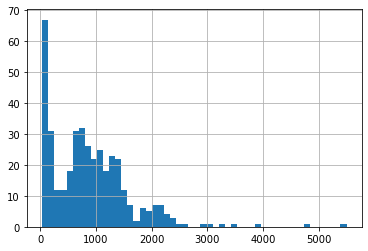

In [15]:
sm.zones['area'].hist(bins=50)

In [16]:
# What are the highest populated zones
sm.zones.sort_values('area').tail(15)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,geometry,population,area,urbanisation,lau_id
DE406,DE,Dahme-Spreewald,3,DE406,DE406,"MULTIPOLYGON (((13.69974 52.37788, 13.70163 52...",169067,2274.53,3.0,12061
DEE04,DE,Altmarkkreis Salzwedel,3,DEE04,DEE04,"POLYGON ((11.58716 52.45869, 11.58189 52.44882...",83765,2293.35,3.0,15081
DE929,DE,Region Hannover,3,DE929,DE929,"POLYGON ((9.73462 52.63830, 9.74099 52.63166, ...",1157624,2297.13,2.0,3241
DEE07,DE,Börde,3,DEE07,DEE07,"POLYGON ((11.58716 52.45869, 11.63967 52.46903...",171734,2366.92,3.0,15083
DED2C,DE,Bautzen,3,DED2C,DED2C,"MULTIPOLYGON (((14.44777 51.54207, 14.45160 51...",300880,2395.61,3.0,14625
DEE0D,DE,Stendal,3,DEE0D,DEE0D,"MULTIPOLYGON (((12.12681 52.89020, 12.12271 52...",111982,2423.41,3.0,15090
DE40D,DE,Ostprignitz-Ruppin,3,DE40D,DE40D,"POLYGON ((12.98468 53.16499, 12.99058 53.15810...",99078,2526.55,3.0,12068
DE40E,DE,Potsdam-Mittelmark,3,DE40E,DE40E,"MULTIPOLYGON (((12.72390 52.53984, 12.71630 52...",214664,2592.06,3.0,12069
DE949,DE,Emsland,3,DE949,DE949,"POLYGON ((7.61188 53.05771, 7.62809 53.05083, ...",325657,2883.64,3.0,3454
DE40I,DE,Uckermark,3,DE40I,DE40I,"POLYGON ((14.41216 53.32964, 14.41496 53.32335...",119552,3077.01,3.0,12073


### Disaggregating zones

It may be useful to further disaggregate zones for these potential reasons:
* The area is too large
* The population is too high
* The zone surrounds another zone what makes it impossible to find a demand centroid that is geographically not unrealistically close to the enclosed zone
* They include mainland and islands

In [17]:
# First, create own zone for the city of Hannover
hannover = geometry.Point((9.738611,52.374444)).buffer(0.05)
sm.zones.loc['DE929_city'] = ['DE', 'Hannover', 3, 'DE929_city', 'DE929', hannover, 1157624, 204.3, 1, 3241001]
# Alter the region parameters
region = sm.zones.loc['DE929']
sm.zones.loc['DE929', 'geometry'] = region['geometry'].difference(hannover)
sm.zones.loc['DE929', 'area'] = region['area'] - 204.3
sm.zones.loc['DE929', 'population'] = region['population'] # parametrisation comes later

<AxesSubplot:>

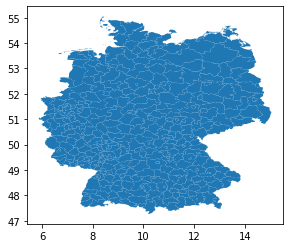

In [18]:
sm.zones.plot()

In [19]:
# List of zones to disaggregate with the geometric lines where to cut them
disagg_zones = [
    # Size or geometry
    ('DE80J', geometry.LineString([(12.88,54), (13.1,53.15)]), 2),
    ('DE80O', geometry.LineString([(11.44,53.56), (11.61,53.2)]), 2),
    ('DE80N', geometry.LineString([(13.9,53.82), (13.72,53.68)]), 3),
    ('DE80K', geometry.LineString([(12.18,54.08), (12.18,53.62)]), 2),
    ('DE949', geometry.LineString([(7.06,52.82), (7.66,52.72)]), 2),
    ('DED2C', geometry.LineString([(14.17,51.55), (14.23,51.07)]), 2),
    ('DEA57', geometry.LineString([(8.4,51.43), (8.59,51.28)]), 2),
    ('DE91C', geometry.LineString([(10,51.63), (10.1,51.4)]), 2),
    ('DEG0A', geometry.LineString([(10.98,51.44), (11.01,51.26)]), 2),
    ('DED53', geometry.LineString([(13.03,51.66), (12.8,51.43)]), 2),
    ('DEB3J', geometry.LineString([(8.15,49.97), (8.12,49.88)]), 2),
    ('DEB13', geometry.LineString([(7.66,50.8), (7.74,50.7)]), 2),
    ('DEB3E', geometry.LineString([(8.24,49.14), (8.37,49.07)]), 2),
    ('DE719', geometry.LineString([(9.2,50.35), (9.3,50.1)]), 2),
    # Population
    ('DEA36', geometry.LineString([(7.25,51.81), (7.1,51.58)]), 2),
    ('DE300', geometry.LineString([(13.37,52.64), (13.43,52.4)]), 2),
    # Islands
    #('DE94C', geometry.LineString([(), ()]), 2), # Ostfriesische Inseln
    #('DE947', geometry.LineString([(), ()]), 2),
    #('DE94H', geometry.LineString([(), ()]), 2),
    #('DE94A', geometry.LineString([(), ()]), 2),
    ('DEF07', geometry.LineString([(8.59,54.91), (8.52,54.81)]), 2), # Sylt
    ('DEF08', geometry.LineString([(10.96,54.43), (11.2,54.38)]), 2), # Fehmann
    ('DE80L', geometry.LineString([(13.05,54.48), (13.12,54.29), (13.42,54.2)]), 2), # Rügen
    # Enclosings
    ('DE929', geometry.LineString([(9.72,52.19), (9.68,52.62)]), 2),
    ('DE91B', geometry.LineString([(10.35,52.23), (10.4,51.97)]), 2),
    ('DE94E', geometry.LineString([(8.1,52.27), (8.14,52.46)]), 2),
    ('DEA5C', geometry.LineString([(7.58,51.56), (7.71,51.62)]), 2),
    ('DE734', geometry.LineString([(9.39,51.3), (9.33,51.22)]), 2),
    ('DEG0P', geometry.LineString([(10.35,50.98), (10.53,50.92)]), 2),
    ('DEG0G', geometry.LineString([(11.15,51.04), (11.53,50.89)]), 2),
    ('DEE0B', geometry.LineString([(11.73,51.45), (12.2,51.42)]), 2),
    ('DEE05', geometry.LineString([(12.18,51.87), (11.97,51.89)]), 2),
    ('DE40G', geometry.LineString([(14.17,51.88), (14.78,51.61)]), 2),
    ('DE249', geometry.LineString([(11.9,50.44), (11.93,50.13)]), 2),
    ('DE246', geometry.LineString([(11.51,50.01), (11.72,49.78)]), 2),
    ('DE245', geometry.LineString([(11.12,49.79), (10.71,49.99)]), 2),
    ('DE247', geometry.LineString([(11.05,50.18), (10.8,50.4)]), 2),
    ('DE26B', geometry.LineString([(10.12,50.12), (10.21,50.04), (10.34,50.025)]), 2),
    ('DE26C', geometry.LineString([(10.09,49.75), (9.71,49.87)]), 2),
    ('DE264', geometry.LineString([(9.16,50.11), (9.13,49.96)]), 2),
    ('DEB25', geometry.LineString([(6.6,49.92), (6.8,49.54)]), 2),
    ('DEA2C', geometry.LineString([(6.99,50.81), (7.07,50.74)]), 2),
    ('DEB3F', geometry.LineString([(7.7,49.48), (7.6,49.54)]), 2),
    ('DEB3K', geometry.LineString([(7.79,49.33), (7.44,49.11)]), 2),
    ('DEB3H', geometry.LineString([(7.95,49.27), (8.28,49.11)]), 2),
    ('DEB33', geometry.LineString([(7.93,49.16), (8.05,49.3)]), 2),
    ('DE715', geometry.LineString([(8.65,49.59), (8.63,49.75)]), 3),
    ('DE128', geometry.LineString([(8.82,49.40), (8.74,49.39), (8.73,49.2)]), 3),
    ('DE123', geometry.LineString([(8.55,49.95), (8.53,48.96), (8.55,48.945)]), 3),
    ('DE124', geometry.LineString([(8.46,48.78), (8.28,48.73), (7.77,48.88), (8.19,48.46), (8.25,48.69)]), 3),
    ('DE12B', geometry.LineString([(8.73,48.9), (8.71,49.03)]), 2),
    ('DE118', geometry.LineString([(9.09,49.3), (9.28,48.99)]), 2),
    ('DE145', geometry.LineString([(9.93,48.37), (9.66,48.54)]), 2),
    ('DE132', geometry.LineString([(7.89,47.93), (7.93,47.85)]), 2),
    ('DE256', geometry.LineString([(10.46,49.45), (10.7,49.1)]), 2),
    ('DE257', geometry.LineString([(11.03,49.6), (11.035,49.632)]), 2),
    ('DE234', geometry.LineString([(11.53,49.45), (12.08,49.45)]), 2),
    ('DE237', geometry.LineString([(12.26,49.83), (12.04,49.53)]), 2),
    ('DE227', geometry.LineString([(12.43,48.69), (11.97,48.42)]), 2),
    ('DE238', geometry.LineString([(12.24,49.19), (12.03,48.9)]), 2),
    ('DE21H', geometry.LineString([(11.68,48.12), (11.78,48.13)]), 2),
    ('DE21K', geometry.LineString([(11.89,47.83), (12.43,47.85)]), 2),
    ('DE228', geometry.LineString([(13.38,48.58), (13.16,48.73)]), 2),
    ('DE22B', geometry.LineString([(12.42,48.92), (12.84,48.82)]), 2)]

In [20]:
# Slice the whole list
for nut, cut, n in disagg_zones:
    polys = ops.split(sm.zones.loc[nut, 'geometry'], cut)
    # Sort polygons by area
    def area(poly):
        return poly.area
    polys = sorted([p for p in polys], key=area) # lowest first
    # Create new zones with share of area
    # Population shares come later in prep16
    area = sm.zones.loc[nut, 'geometry'].area
    for i in range(1, n+1):
        row = sm.zones.loc[nut]
        row['NUTS_NAME'] = row['NUTS_NAME'] + ' ' + str(i)
        row['FID'] = row['FID'] + '_' + str(i)
        row['geometry'] = polys[-i]
        row['area'] = polys[-i].area / area * row['area']
        # population parametrisation comes later (prep16)
        sm.zones.loc[nut+'_'+str(i)] = row
    # Drop the old zone
    sm.zones.drop(nut, inplace=True)

<AxesSubplot:>

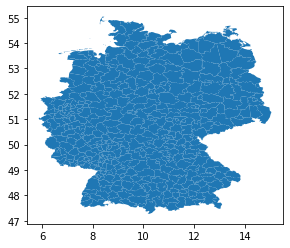

In [21]:
sm.zones.plot()

### Save model

In [22]:
# Saving model zones as geojson
sm.to_json(model_path + 'de_zones_disagg', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.54it/s]
